## 왜? SAVE만 밤시간대에 사용량이 많을까...

## 난방 여부와의 분석

### * 데이터 로드 및 동일 집끼리 병합

In [1]:
import os
os.chdir('../')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from module.util_main import downsampling, dim_reduct
from collections import defaultdict
font = {'size': 16, 'family':"Malgun Gothic"}
matplotlib.rc('font', **font)

from pathlib import Path

# 에너지 데이터 로드
SAVE = pd.read_csv('data/SAVE/power_0428.csv', index_col=0)
SAVE = SAVE.iloc[84:,:]
SAVE.index = pd.to_datetime(SAVE.index)
SAVE[SAVE == 0] = np.nan

# 라벨 
SAVE_label = pd.read_csv('data/SAVE/save_household_survey_data_v0-3.csv', index_col = 0)
SAVE_label = SAVE_label.T
SAVE_label.columns = SAVE_label.columns.astype(str)

helper_dict = defaultdict(list)
for col in SAVE.columns:
    helper_dict[col[2:]].append(col)

# 동일 집끼리 병합
drop_cols = []
invalid_idx_list = []
for key,value in helper_dict.items():
    if len(value) >= 2:
        valid_idx_1 = ~pd.isnull(SAVE[value[1]])

        # replace value
        SAVE[value[0]][valid_idx_1] = SAVE[value[1]][valid_idx_1]

        # delete remain
        drop_cols.append(value[1])

# drop cols
SAVE.drop(columns = drop_cols, inplace = True)

# label과 data의 column 맞춤
SAVE.columns = [c[2:] for c in SAVE.columns]

print('Done')

Done


In [2]:
SAVE_label

BMG_ID,956600023,956600025,956600047,956600048,956600076,956610255,956610369,956610568,956610600,956610702,...,956663160,956663178,956663185,956663188,956663192,956663193,956663197,956663199,956663200,956663203
Intervention,2,3,2,1,1,3,3,1,1,1,...,4,3,3,2,4,2,3,1,4,2
surveyMode,CAPI Survey,CAPI Survey,CAPI Survey,CAPI Survey,CAPI Survey,CAPI Survey,CAPI Survey,CAPI Survey,CAPI Survey,CAPI Survey,...,CATI Survey,CAWI Survey,CAPI Survey,CATI Survey,CATI Survey,CAPI Survey,CATI Survey,CATI Survey,CAWI Survey,CAPI Survey
InterviewDate,2018-08-23,2018-09-06,2018-09-29,2018-09-29,2018-09-29,2018-09-22,2018-09-22,2018-09-30,2018-09-29,2018-09-20,...,2017-05-24,2017-02-10,2018-06-02,2017-03-23,2017-03-14,2017-10-11,2017-03-20,2017-03-15,2017-02-10,2017-10-12
wgtRakeAgeTenure,0.733782,0.975945,0.699298,1.62027,0.699298,0.921949,0.921949,0.61337,0.743432,0.620826,...,0.647339,0.527831,0.582643,0.647339,0.582643,0.582643,0.582643,0.582643,0.582643,0.582643
Q2,1,2,2,2,3,5,5,2,2,2,...,4,2,4,1,4,5,2,6,2,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
UrbanRural_Name,1,2,1,1,1,2,2,2,2,2,...,2,2,2,2,2,2,2,2,2,2
UrbanRural_SubName,Rural village: OA is assigned to the 'village'...,Urban city and town: OA falls within a built-u...,Rural hamlet and isolated dwellings: OA is ass...,Rural hamlet and isolated dwellings: OA is ass...,Rural hamlet and isolated dwellings: OA is ass...,Urban city and town: OA falls within a built-u...,Urban city and town: OA falls within a built-u...,Urban city and town: OA falls within a built-u...,Urban city and town: OA falls within a built-u...,Urban city and town: OA falls within a built-u...,...,Urban city and town: OA falls within a built-u...,Urban city and town: OA falls within a built-u...,Urban city and town: OA falls within a built-u...,Urban city and town: OA falls within a built-u...,Urban city and town: OA falls within a built-u...,Urban city and town: OA falls within a built-u...,Urban city and town: OA falls within a built-u...,Urban city and town: OA falls within a built-u...,Urban city and town: OA falls within a built-u...,Urban city and town: OA falls within a built-u...
quartile,2,3,2,2,2,2,2,3,3,4,...,1,1,1,1,1,1,1,1,1,1
quintile,2,4,2,2,2,3,3,4,3,5,...,1,1,1,1,1,1,1,1,1,1


In [3]:
from module.util_save import matching_id

data_f, label_f = matching_id(SAVE, SAVE_label, 'Q3_12')

### 전기난방과 아닌집의 conditional distribution

In [4]:
start_date = pd.to_datetime('2017-01-01 00:00:00')
end_date = pd.to_datetime('2017-02-01 23:00:00')

# dim reduct
data_1 = data_f.loc[start_date:end_date,label_f == 1].values
data_1, _ = dim_reduct(data_1, 24*4, 0)
data_1 = downsampling(data_1, 4)

data_2 = data_f.loc[start_date:end_date,label_f != 1].values
data_2, _ = dim_reduct(data_2, 24*4, 0)
data_2 = downsampling(data_2, 4)


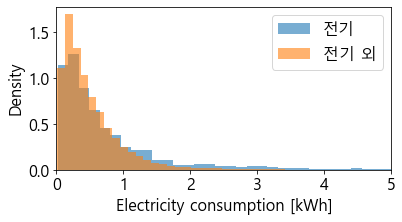

In [6]:
plt.figure(figsize = (6,3))
plt.title('')
plt.hist(data_1[:,:].reshape(-1), label = '전기', bins = 100, alpha = 0.6, density = True)
plt.hist(data_2[:,:].reshape(-1), label = '전기 외', bins = 100, alpha = 0.6, density = True)
plt.ylabel('Density')
plt.xlabel('Electricity consumption [kWh]')
plt.legend()
plt.xlim(0, 5)
plt.show()

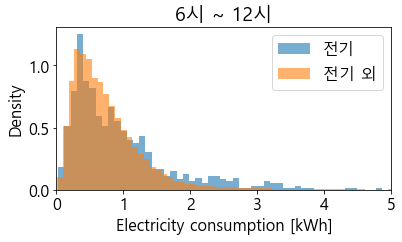

In [7]:
plt.figure(figsize = (6,3))
plt.title('6시 ~ 12시')
plt.hist(data_1[:,0:6].reshape(-1), label = '전기', bins = 100, alpha = 0.6, density = True)
plt.hist(data_2[:,0:6].reshape(-1), label = '전기 외', bins = 100, alpha = 0.6, density = True)
plt.ylabel('Density')
plt.xlabel('Electricity consumption [kWh]')
plt.legend()
plt.xlim(0, 5)
plt.show()

=> 큰 차이가 없어 보임..

## 사람수 분석

### 시간대별 correlation

In [77]:
from module.util_save import matching_id
data_f, label_f = matching_id(SAVE, SAVE_label, 'Q2')
data_f, data_id = dim_reduct(data_f.values, 24*4, 0)
data_f = downsampling(data_f, 4)
label_f = label_f[data_id]

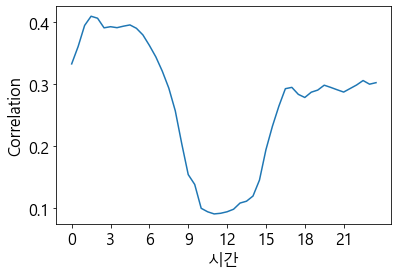

In [76]:
corr_list = []
for i in range(48):
    corr_list.append(np.corrcoef(data_f[:,i], label_f)[0,1])
plt.plot(corr_list)
plt.xlabel('시간')
plt.xticks(range(48)[::6], (np.array(range(48))/2)[::6].astype(int))
plt.ylabel('Correlation')
plt.show()

### 사람수별로 histogram

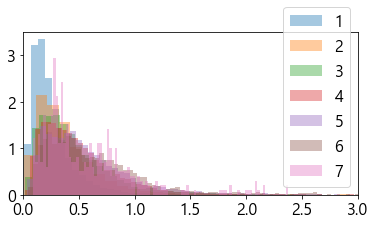

In [36]:
plt.figure(figsize=(6,3))
for i in range(1, 8):
    plt.hist(data_f[label_f == i].reshape(-1), label = i, \
    bins = 100, alpha = 0.4, density = True)
plt.xlim(0, 3)
plt.legend()
plt.show()

### 시간별 분포?

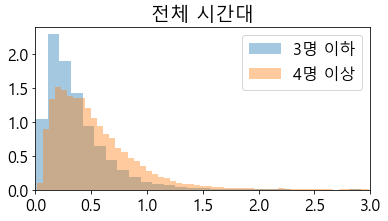

In [66]:
plt.figure(figsize=(6,3))
plt.title('전체 시간대')
plt.hist(data_f[label_f <= 3].reshape(-1), label = '3명 이하', \
bins = 100, alpha = 0.4, density = True)
plt.hist(data_f[label_f >= 4].reshape(-1), label = '4명 이상', \
bins = 100, alpha = 0.4, density = True)
plt.xlim(0, 3)
plt.legend()
plt.show()

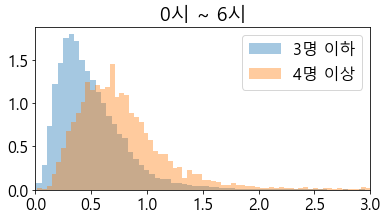

In [78]:
plt.figure(figsize=(6,3))
plt.title('0시 ~ 6시')
plt.hist(data_f[label_f <= 3,:6].reshape(-1), label = '3명 이하', \
bins = 100, alpha = 0.4, density = True)
plt.hist(data_f[label_f >= 4,:6].reshape(-1), label = '4명 이상', \
bins = 100, alpha = 0.4, density = True)
plt.xlim(0, 3)
plt.legend()
plt.show()

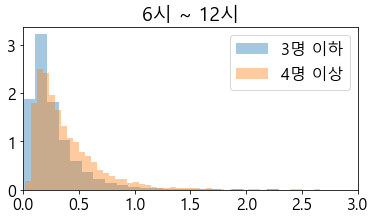

In [65]:
plt.figure(figsize=(6,3))
plt.title('6시 ~ 12시')
plt.hist(data_f[label_f <= 3,6:12].reshape(-1), label = '3명 이하', \
bins = 100, alpha = 0.4, density = True)
plt.hist(data_f[label_f >= 4,6:12].reshape(-1), label = '4명 이상', \
bins = 100, alpha = 0.4, density = True)
plt.xlim(0, 3)
plt.legend()
plt.show()